# Ensemble Methods

In [1]:
# Main data packages. 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import imblearn

import datetime

import warnings
warnings.filterwarnings('ignore')

## Data

For input data we are concentrating on those data sets which performed well with our PCA approach:

1. df_7
2. df_10_compact
3. df_11_compact
4. df_12_compact
5. df_13
6. df_14

Those DataFrames with "compact" in their names are based on other Dataframes BUT only contain those features which had at least some correlation with the target value "rebap_eur_mwh". This correaltion was identified via Seaborn correlation map.

In [2]:
df_7 = pd.read_csv("data/PCA Data Sets/EQ_epex_da_last_prognosis_count.csv")

In [3]:
df_7['timestamp']=df_7['timestamp'].astype('datetime64')

In [4]:
df_10 = pd.read_csv("data/PCA Data Sets/es_fc_total_renewables_ts.csv")

In [5]:
df_10['dt_start_utc']=df_10['dt_start_utc'].astype('datetime64')

In [6]:
df_10_compact = df_10[['dt_start_utc', "TTG_power_mw"]].copy()

In [7]:
df_11 = pd.read_csv("data/PCA Data Sets/es_fc_wind_offshore_ts.csv")

In [8]:
df_11['dt_start_utc']=df_11['dt_start_utc'].astype('datetime64')

In [9]:
df_11_compact = df_11[['dt_start_utc', "DE_power_mw", "TTG_power_mw"]].copy()

In [10]:
df_12 = pd.read_csv("data/PCA Data Sets/es_fc_wind_onshore_ts.csv")

In [11]:
df_12['dt_start_utc']=df_12['dt_start_utc'].astype('datetime64')

In [12]:
df_12_compact = df_12[['dt_start_utc', "50Hertz_power_mw", "DE_power_mw", "TTG_power_mw"]].copy()

In [13]:
df_13 = pd.read_csv("data/PCA Data Sets/wind_speed_ts.csv")

In [14]:
df_13['dt_start_utc']=df_13['dt_start_utc'].astype('datetime64')

In [15]:
df_14 = pd.read_csv("data/PCA Data Sets/imbalance_de_labeled.csv")

In [16]:
df_14['dt_start_utc']=df_14['dt_start_utc'].astype('datetime64')

In [17]:
df_14 = df_14.drop(["power_mw"], axis=1)

In [18]:
from apymb import *

df_ensemble = align(df_7, df_10_compact, df_11_compact, df_12_compact, df_13, df_14)

## THIS IS OPTIONAL! It seems to decrease a little bit the accuracy of the Algorithms if Outliers are removed, but needs to be checked once at least before doing this step each time

Filter out again those rebap prizes that are not within 3 Standard deviations of the mean:
Now we will get rid of those rebap prize outliers outside the +/- 3 Standard Deviation range with the following code line:

In [19]:
std_dev = 3*df_ensemble['6_rebap_eur_mwh'].std()
df_ensemble = df_ensemble[np.abs(df_ensemble['6_rebap_eur_mwh'] - df_ensemble['6_rebap_eur_mwh'].mean()) <= std_dev]

### Define new classification column named "rebap_price_class" in which the rebap price_range is translated to two classes:

- Class 0: Rebap prize below 0 €
- Class 1: Rebap prize above 0 €

In [20]:
df_ensemble["rebap_price_class"] = np.nan
for i in range (len(df_ensemble["rebap_price_class"])):
    if df_ensemble["6_rebap_eur_mwh"][i] <= 0:
        df_ensemble["rebap_price_class"][i] = 0
    else:
        df_ensemble["rebap_price_class"][i]= 1
        
df_ensemble["rebap_price_class"] = df_ensemble["rebap_price_class"].astype('int')

## Eliminate the original target feature "rebap_eur_mwh" from the Dataframe (we want to predict the target class in "rebap_price_class":

In [21]:
df_ensemble = df_ensemble.drop(['6_rebap_eur_mwh'], axis= 1)

In [22]:
df_ensemble.to_csv("data/ensemble_df.csv")

## Train-test Split plus Smote for the Training Data Set

In [23]:
from sklearn.model_selection import train_test_split
X = df_ensemble.drop(["rebap_price_class"],axis=1)
y = df_ensemble["rebap_price_class"]

In [24]:
X.head()

,1_prognosis,2_TTG_power_mw,3_DE_power_mw,3_TTG_power_mw,4_50Hertz_power_mw,4_DE_power_mw,4_TTG_power_mw,5_area_1_windspeed_ms,5_area_2_windspeed_ms,5_area_4_windspeed_ms,...,5_area_100_windspeed_ms,5_area_101_windspeed_ms,5_area_102_windspeed_ms,5_area_103_windspeed_ms,5_area_104_windspeed_ms,5_area_105_windspeed_ms,5_area_106_windspeed_ms,5_area_107_windspeed_ms,5_area_108_windspeed_ms,5_area_109_windspeed_ms
2018-12-31 23:00:00,30.44,4021.0,5042.0,4021.0,7256.0,18224.0,3117.0,9.523,9.691,14.258,...,14.044,13.405,13.080,15.056,13.411,13.185,13.311,13.716,13.416,13.316
2018-12-31 23:15:00,30.44,0.0,5061.0,4036.0,7477.0,18652.0,3117.0,9.097,10.031,13.564,...,13.962,13.147,13.404,14.168,13.769,13.415,14.100,13.492,13.470,13.156
2018-12-31 23:30:00,30.44,4050.0,5079.0,4050.0,7706.0,19095.0,3117.0,8.654,9.491,15.997,...,15.163,14.253,13.640,15.508,13.822,13.415,14.742,14.559,14.171,13.528
2018-12-31 23:45:00,30.44,0.0,5094.0,4061.0,7928.0,19548.0,3117.0,8.478,9.411,16.436,...,15.826,14.649,13.640,15.806,13.822,14.343,15.156,14.916,14.171,14.125
2019-01-01 00:00:00,23.56,4076.0,5112.0,4076.0,8142.0,19999.0,3117.0,8.601,9.741,15.792,...,15.249,14.324,13.640,15.747,14.817,14.279,14.204,14.827,14.547,14.207


In [25]:
hours_shift = 6

# Shift the Data to represent the fact that not all Data are available immediately
X = X.shift(int(hours_shift*4))
y = y[int(hours_shift*4):]
X = X.dropna()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) 

In [26]:
# balance out every target class imbalance via SMOTE (ONLY for the Training Data!):
from imblearn.over_sampling import SMOTE

oversample = SMOTE()
X_train, y_train = oversample.fit_resample(X_train, y_train)

## Define a train_predict function (taken from neuefische Notebook No.4 for ensemble Methods) that trains and evaluates different ML Models and returns the most important scores for each Model in a result list:

In [27]:
from time import time

# TODO: Import two metrics from sklearn - fbeta_score and accuracy_score
from sklearn.metrics import fbeta_score, accuracy_score

# Define a train and evaluation function 
def train_predict(learner, sample_size, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    
    results = {}
    
    # TODO: Fit the learner to the training data using slicing with 'sample_size'
    start = time() # Get start time
    learner = learner.fit(X_train[:sample_size], y_train[:sample_size])
    end = time() # Get end time
    
    # TODO: Calculate the training time
    results['train_time'] = end - start
        
    # TODO: Get the predictions on the test set,
    #       then get predictions on the first 300 training samples
    start = time() # Get start time
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train[:300])
    end = time() # Get end time
    
    # TODO: Calculate the total prediction time
    results['pred_time'] = end - start
            
    # TODO: Compute accuracy on the first 300 training samples
    results['acc_train'] = accuracy_score(y_train[:300], predictions_train)
        
    # TODO: Compute accuracy on test set
    results['acc_test'] = accuracy_score(y_test,predictions_test)
    
    # TODO: Compute F-score on the the first 300 training samples
    results['f_train'] = fbeta_score(y_train[:300], predictions_train, beta=0.5)
        
    # TODO: Compute F-score on the test set
    results['f_test'] = fbeta_score(y_test, predictions_test, beta=0.5)
       
    # Success
    print ("{} trained on {} samples.".format(learner.__class__.__name__, sample_size))
        
    # Return the results
    return results

In [28]:
# TODO: Import the three supervised learning models from sklearn
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier

# TODO: Initialize the three models, the random states are set to 101 so we know how to reproduce the model later
clf_A = RandomForestClassifier(random_state=42)
clf_B = DecisionTreeClassifier(random_state=42)
clf_C = AdaBoostClassifier(random_state=42)

# TODO: Calculate the number of samples for 1%, 10%, and 100% of the training data
samples_1 = int(round(len(X_train) / 100))
samples_10 = int(round(len(X_train) / 10))
samples_100 = len(X_train)

# Collect results on the learners
results = {}
for clf in [clf_A, clf_B, clf_C]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = \
        train_predict(clf, samples, X_train, y_train, X_test, y_test)

RandomForestClassifier trained on 700 samples.
RandomForestClassifier trained on 7001 samples.
RandomForestClassifier trained on 70010 samples.
DecisionTreeClassifier trained on 700 samples.
DecisionTreeClassifier trained on 7001 samples.
DecisionTreeClassifier trained on 70010 samples.
AdaBoostClassifier trained on 700 samples.
AdaBoostClassifier trained on 7001 samples.
AdaBoostClassifier trained on 70010 samples.


In [29]:
#Printing out the values
for i in results.items():
    print (i[0])
    display(pd.DataFrame(i[1]).rename(columns={0:'1%', 1:'10%', 2:'100%'}))

RandomForestClassifier


,1%,10%,100%
train_time,0.386095,5.075344,75.537314
pred_time,0.104109,0.185805,0.337084
acc_train,1.000000,1.000000,1.000000
acc_test,0.818096,0.827606,0.829395
f_train,1.000000,1.000000,1.000000
f_test,0.853891,0.860454,0.898947


DecisionTreeClassifier


,1%,10%,100%
train_time,0.047780,0.979088,13.502002
pred_time,0.006483,0.007354,0.010458
acc_train,1.000000,1.000000,1.000000
acc_test,0.710856,0.741832,0.745692
f_train,1.000000,1.000000,1.000000
f_test,0.829893,0.845529,0.863412


AdaBoostClassifier


,1%,10%,100%
train_time,0.397424,3.663197,39.584742
pred_time,0.128037,0.130879,0.142744
acc_train,0.880000,0.810000,0.663333
acc_test,0.783448,0.816966,0.639864
f_train,0.901826,0.843882,0.842333
f_test,0.847353,0.853042,0.828228


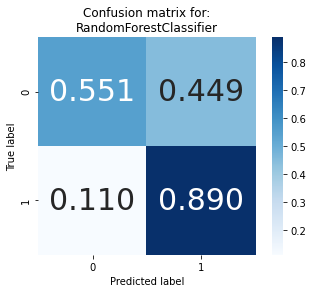

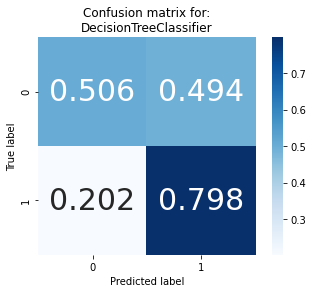

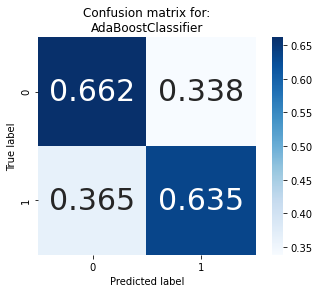

In [30]:
#Visualizing the confusion matrix for each classifier
from sklearn.metrics import confusion_matrix, classification_report, roc_curve
import seaborn as sns

for i,model in enumerate([clf_A,clf_B, clf_C]):
    cm = confusion_matrix(y_test, model.predict(X_test))
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] # normalize the data

    # view with a heatmap
    plt.figure(i)
    sns.heatmap(cm, annot=True, annot_kws={"size":30}, 
            cmap='Blues', square=True, fmt='.3f')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title('Confusion matrix for:\n{}'.format(model.__class__.__name__));
    #plt.savefig(f'Confusion matrix for:{format(model.__class__.__name__)}.png', transparent=True)

# Try 5-Bucket classification with the Ensemble Methods
Let us now test how well our 3 Ensemble Methods work for a 5-Bucket approach of the target feature:
- class 0: Rebap price < ca. 20% Percentile
- class 1: Rebap price < ca. 40% Percentile
- class 2: Rebap price < ca. 60% Percentile
- class 3: Rebap price < ca. 80% Percentile
- class 4: Rebap price < ca. 100% Percentile

We do not take the precise values for the different percentiles, just an approximation (with the exception of class 0, which will be determined as "every Rebap price <= 0€".

In [31]:
# We first have to define our dataframe:

df_ensemble_5_bucket = align(df_7, df_10_compact, df_11_compact, df_12_compact, df_13, df_14)

## THIS IS OPTIONAL! It seems to decrease a little bit the accuracy of the Algorithms if Outliers are removed, but needs to be checked once at least before doing this step each time

Filter out again those rebap prizes that are not within 3 Standard deviations of the mean:
Now we will get rid of those rebap prize outliers outside the +/- 3 Standard Deviation range with the following code line:

In [32]:
"""
std_dev = 3*df_ensemble_5_bucket['6_rebap_eur_mwh'].std()
df_ensemble_5_bucket = df_ensemble_5_bucket[np.abs(df_ensemble_5_bucket['6_rebap_eur_mwh'] - df_ensemble_5_bucket['6_rebap_eur_mwh'].mean()) <= std_dev]
"""

"\nstd_dev = 3*df_ensemble_5_bucket['6_rebap_eur_mwh'].std()\ndf_ensemble_5_bucket = df_ensemble_5_bucket[np.abs(df_ensemble_5_bucket['6_rebap_eur_mwh'] - df_ensemble_5_bucket['6_rebap_eur_mwh'].mean()) <= std_dev]\n"

## Calculate the percentile values for 20%, 40%, 60%, 80%, 100%:

In [33]:
rebap_20_percentile = df_ensemble_5_bucket["6_rebap_eur_mwh"].quantile(0.2)
rebap_40_percentile = df_ensemble_5_bucket["6_rebap_eur_mwh"].quantile(0.4)
rebap_60_percentile = df_ensemble_5_bucket["6_rebap_eur_mwh"].quantile(0.6)
rebap_80_percentile = df_ensemble_5_bucket["6_rebap_eur_mwh"].quantile(0.8)
rebap_100_percentile = df_ensemble_5_bucket["6_rebap_eur_mwh"].quantile(1)

print(rebap_20_percentile, rebap_40_percentile, rebap_60_percentile, rebap_80_percentile, rebap_100_percentile)

2.85 22.98600000000002 45.31 62.39 3334.27


Create the new target column "rebap_price_class" based on the roughly rounded 20,40,60,80 and 100% percentiles: 

In [34]:
"""
df_ensemble_5_bucket["rebap_price_class"] = np.nan
for i in range (len(df_ensemble_5_bucket["rebap_price_class"])):
    if df_ensemble_5_bucket["6_rebap_eur_mwh"][i] < -75:
        df_ensemble_5_bucket["rebap_price_class"][i] = 0
    elif -75 <= df_ensemble_5_bucket["6_rebap_eur_mwh"][i] < -25:
        df_ensemble_5_bucket["rebap_price_class"][i]= 1
    elif -25 <= df_ensemble_5_bucket["6_rebap_eur_mwh"][i] < 25:
        df_ensemble_5_bucket["rebap_price_class"][i]= 2
    elif 25 <= df_ensemble_5_bucket["6_rebap_eur_mwh"][i] < 75:
        df_ensemble_5_bucket["rebap_price_class"][i]= 3
    else:
        df_ensemble_5_bucket["rebap_price_class"][i]= 4

df_ensemble_5_bucket["rebap_price_class"] = df_ensemble_5_bucket["rebap_price_class"].astype('int')
"""

'\ndf_ensemble_5_bucket["rebap_price_class"] = np.nan\nfor i in range (len(df_ensemble_5_bucket["rebap_price_class"])):\n    if df_ensemble_5_bucket["6_rebap_eur_mwh"][i] < -75:\n        df_ensemble_5_bucket["rebap_price_class"][i] = 0\n    elif -75 <= df_ensemble_5_bucket["6_rebap_eur_mwh"][i] < -25:\n        df_ensemble_5_bucket["rebap_price_class"][i]= 1\n    elif -25 <= df_ensemble_5_bucket["6_rebap_eur_mwh"][i] < 25:\n        df_ensemble_5_bucket["rebap_price_class"][i]= 2\n    elif 25 <= df_ensemble_5_bucket["6_rebap_eur_mwh"][i] < 75:\n        df_ensemble_5_bucket["rebap_price_class"][i]= 3\n    else:\n        df_ensemble_5_bucket["rebap_price_class"][i]= 4\n\ndf_ensemble_5_bucket["rebap_price_class"] = df_ensemble_5_bucket["rebap_price_class"].astype(\'int\')\n'

## Close to 20,40,60,80,100 Percentile bucket classification approach(try it out!):

In [35]:
df_ensemble_5_bucket["rebap_price_class"] = np.nan
for i in range (len(df_ensemble_5_bucket["rebap_price_class"])):
    if df_ensemble_5_bucket["6_rebap_eur_mwh"][i] <= 0:
        df_ensemble_5_bucket["rebap_price_class"][i] = 0
    elif df_ensemble_5_bucket["6_rebap_eur_mwh"][i] <= 20:
        df_ensemble_5_bucket["rebap_price_class"][i]= 1
    elif df_ensemble_5_bucket["6_rebap_eur_mwh"][i] <= 40:
        df_ensemble_5_bucket["rebap_price_class"][i]= 2
    elif df_ensemble_5_bucket["6_rebap_eur_mwh"][i] <= 60:
        df_ensemble_5_bucket["rebap_price_class"][i]= 3
    else:
        df_ensemble_5_bucket["rebap_price_class"][i]= 4

df_ensemble_5_bucket["rebap_price_class"] = df_ensemble_5_bucket["rebap_price_class"].astype('int')

In [36]:
df_ensemble_5_bucket = df_ensemble_5_bucket.drop(['6_rebap_eur_mwh'], axis= 1)

In [37]:
X2 = df_ensemble_5_bucket.drop(["rebap_price_class"],axis=1)
y2 = df_ensemble_5_bucket["rebap_price_class"]

y2.head()

2018-12-31 23:00:00    0
2018-12-31 23:15:00    0
2018-12-31 23:30:00    1
2018-12-31 23:45:00    2
2019-01-01 00:00:00    0
Freq: 15T, Name: rebap_price_class, dtype: int64

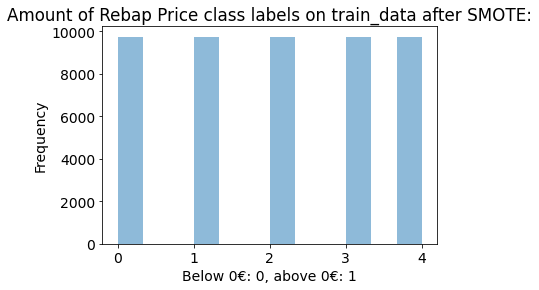

In [38]:
# print(X2.head())
hours_shift = 6

# Shift the Data to represent the fact that not all Data are available immediately
X2 = X2.shift(int(hours_shift*4))
y2 = y2[int(hours_shift*4):]
X2 = X2.dropna()

X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.2, random_state=42)                     

# balance out every target class imbalance via SMOTE (ONLY for the Training Data!):

oversample = SMOTE()
X_train2, y_train2 = oversample.fit_resample(X_train2, y_train2)

# Class Inbalance as a Graph
plt.rcParams.update({'font.size':14})
plt.xlabel('Below 0€: 0, above 0€: 1')
plt.ylabel('Frequency')
plt.title('Amount of Rebap Price class labels on train_data after SMOTE:')
fig = y_train2.plot.hist(bins=12, alpha=0.5)

## Modify the train_predict-function from the binary class approach so that it works with non-binary classifications:

The function is more or less identical to the previous version, but without F-score validation, which only works for binary classification.

In [39]:
from time import time

# TODO: Import two metrics from sklearn - fbeta_score and accuracy_score
from sklearn.metrics import fbeta_score, accuracy_score

# Define a train and evaluation function 
def train_predict_5_bucket(learner, sample_size, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    
    results = {}
    
    # TODO: Fit the learner to the training data using slicing with 'sample_size'
    start = time() # Get start time
    learner = learner.fit(X_train[:sample_size], y_train[:sample_size])
    end = time() # Get end time
    
    # TODO: Calculate the training time
    results['train_time'] = end - start
        
    # TODO: Get the predictions on the test set,
    #       then get predictions on the first 300 training samples
    start = time() # Get start time
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train[:300])
    end = time() # Get end time
    
    # TODO: Calculate the total prediction time
    results['pred_time'] = end - start
            
    # TODO: Compute accuracy on the first 300 training samples
    results['acc_train'] = accuracy_score(y_train[:300], predictions_train)
        
    # TODO: Compute accuracy on test set
    results['acc_test'] = accuracy_score(y_test,predictions_test)
       
    # Success
    print ("{} trained on {} samples.".format(learner.__class__.__name__, sample_size))
        
    # Return the results
    return results

In [40]:
# Collect results on the learners
results = {}
for clf in [clf_A, clf_B, clf_C]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = \
        train_predict_5_bucket(clf, samples, X_train2, y_train2, X_test2, y_test2)

RandomForestClassifier trained on 700 samples.
RandomForestClassifier trained on 7001 samples.
RandomForestClassifier trained on 70010 samples.
DecisionTreeClassifier trained on 700 samples.
DecisionTreeClassifier trained on 7001 samples.
DecisionTreeClassifier trained on 70010 samples.
AdaBoostClassifier trained on 700 samples.
AdaBoostClassifier trained on 7001 samples.
AdaBoostClassifier trained on 70010 samples.


In [41]:
#Printing out the values
for i in results.items():
    print (i[0])
    display(pd.DataFrame(i[1]).rename(columns={0:'1%', 1:'10%', 2:'100%'}))

RandomForestClassifier


,1%,10%,100%
train_time,0.487598,5.575799,49.211959
pred_time,0.174427,0.277438,0.417502
acc_train,1.000000,1.000000,1.000000
acc_test,0.291006,0.399888,0.547117


DecisionTreeClassifier


,1%,10%,100%
train_time,0.059693,0.907552,8.246455
pred_time,0.007071,0.008213,0.009174
acc_train,1.000000,1.000000,1.000000
acc_test,0.239970,0.289606,0.406326


AdaBoostClassifier


,1%,10%,100%
train_time,0.394087,3.661124,25.594174
pred_time,0.138489,0.140193,0.177535
acc_train,0.450000,0.350000,0.316667
acc_test,0.260403,0.321515,0.312558


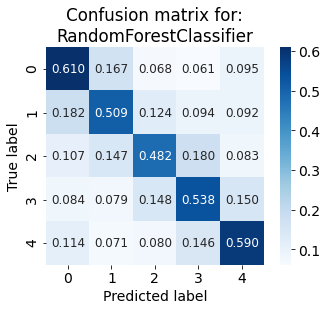

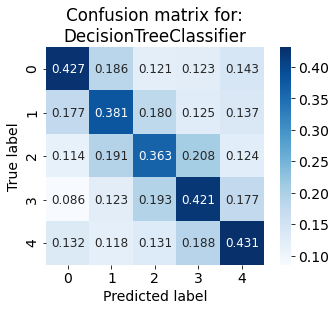

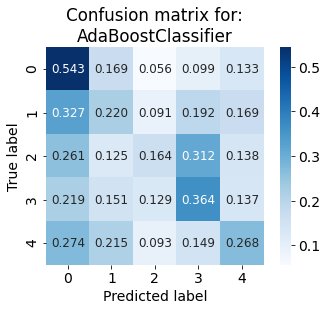

In [42]:
#Visualizing the confusion matrix for each classifier with 5 buckt approach
from sklearn.metrics import confusion_matrix, classification_report, roc_curve

for i,model in enumerate([clf_A,clf_B, clf_C]):
    cm = confusion_matrix(y_test2, model.predict(X_test2))
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] # normalize the data

    # view with a heatmap
    plt.figure(i)
    sns.heatmap(cm, annot=True, annot_kws={"size":12}, 
            cmap='Blues', square=True, fmt='.3f')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title('Confusion matrix for:\n{}'.format(model.__class__.__name__));
    #plt.savefig(f'Confusion matrix for:{format(model.__class__.__name__)}.png', transparent=True)